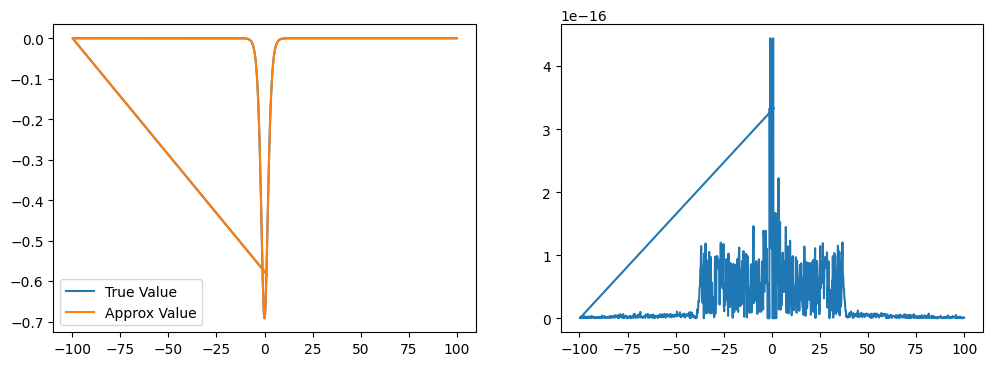

-0.582203108888218
-0.5822031088882177
[0.01815363+1.29700266j 0.05467867+1.29802755j 0.09185577+1.30012387j
 0.13011518+1.3033851j  0.16987969+1.30795231j]
[0.01107914+4.78255592e-05j 0.01121806+1.45003111e-04j
 0.0114958 +2.46628953e-04j 0.011912  +3.55201395e-04j
 0.01246584+4.72412512e-04j]


In [9]:
import matplotlib.pyplot as plt
import scipyx as spx
import scipy.special
import numpy as np
import jax
import jax.numpy.linalg as jli
from jax import numpy as jnp
from jax import scipy as jsp
from jax import value_and_grad, vmap, lax, jit, random
from jax.experimental.sparse import BCOO
from jax.experimental.sparse import COO
from jax._src.api import block_until_ready
from functools import partial
jax.config.update("jax_enable_x64", True)


def bin_entropy(Z):
    X = np.real(Z) / 2
    Y = np.imag(Z) / 2
    temp = (1 - np.tanh(X + 1j * Y)) / 2
    R = temp * np.log(temp) + (1 - temp) * np.log(1 - temp)
    return R

def gen_contour(Em, EM, beta, N, mu=0, function="fermi_dirac"):
    m = (np.pi / (2 * 1)) ** 2
    low_b = (Em - mu) * beta
    high_b = (EM - mu) * beta
    M = np.maximum(np.abs(low_b), np.abs(high_b)) ** 2 + m
    k = (np.sqrt(M - m) - 1) / (np.sqrt(M - m) + 1)
    K = scipy.special.ellipk(k ** 2)
    Kp = scipy.special.ellipk(1 - k ** 2)
    t = 1j * Kp / 2 - K + np.linspace(0.5, N - 0.5, N) * (2 * K / N)
    ej = spx.ellipj(t, k ** 2)
    sn = ej[0]  # Jacobi sine function
    cn = ej[1]  # Jacobi cosine function
    dn = ej[2]  # Delta amplitude
    z = np.sqrt(m * M) * (1 / k + sn) / (1 / k - sn)
    xi = np.sqrt(z - m)
    neg_xi = -xi
    w_xi = (-2 * K * np.sqrt(m * M)) / (np.pi * N * k) * cn * dn / xi / ((1 / k - sn) ** 2)
    w_neg_xi = (-2 * K * np.sqrt(m * M)) / (np.pi * N * k) * cn * dn / neg_xi / ((1 / k - sn) ** 2)
    w = np.hstack([w_xi, w_neg_xi])
    xi = np.hstack([xi, -xi])
    if function == "fermi_dirac":
        w = w * complex_square_root_fermidirac(xi)
    
    elif function == "bin_entropy":
        w = w * complex_binEntropy_fermiDirac(xi)
        
    return xi / beta, w / beta

def contour_f(x,xi,w):
    """
    Evaluate the contour integral of a function f along a contour defined by poles xi and weights w.
    """
    value = sum(w/(xi-x))
    return np.imag(value)

Em = -100
EM = 100
beta = 1
N = 100 
xi, w = gen_contour(Em, EM, beta, N, mu=0, function="bin_entropy")

vals = np.linspace(Em, EM, 1000)
vals[0] =1
true_val = -np.log(1 + np.exp(vals)) /(1+np.exp(vals)) - np.log(1 + np.exp(-vals))/(1+np.exp(-vals))
approx_val = [contour_f(val, xi, w) for val in vals]


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vals, true_val, label="True Value")
plt.plot(vals, approx_val, label="Approx Value")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(vals, np.abs(true_val - approx_val))
plt.show()



print(true_val[0])
print(approx_val[0])

print(xi[:5])
print(w[:5])

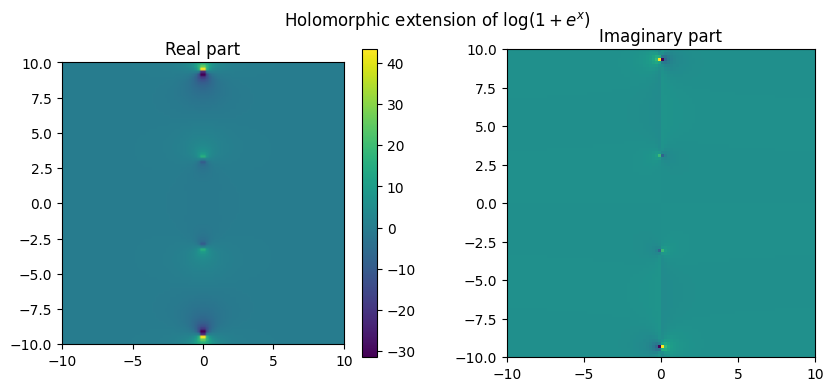

In [4]:
import numpy 
import numpy as np
import matplotlib.pyplot as plt

def bin_entropy(Z):
    X = np.real(Z) / 2
    Y = np.imag(Z) / 2
    temp = (1 - np.tanh(X + 1j * Y)) / 2
    R = temp * np.log(temp) + (1 - temp) * np.log(1 - temp)
    return R
    # return temp

def holomorphic_log(Z):
    Y = np.angle(Z)
    X = np.real(Z)
    r = np.abs(Z) 


    # print("r", r)
    # print(Y[10][99])
    # force theta to be in [-pi/2, 3pi/2)
    # print(Y[1059])
    # theta =  - 2 * np.pi * np.floor((Y + np.pi / 2) / (2* np.pi)) + Y 
    # print("theta", np.max(theta), np.min(theta))
    theta = Y
        # np.argmax returns the index in the flattened array
    # flat_index = np.argmax(theta)

    # Convert the flattened index to a tuple of coordinates
    # max_index = np.unravel_index(flat_index, theta.shape)
    # print("max_index", max_index)
    return np.log(r) + 1j * theta

def complex_log_onepluse(z):
    # X = np.real(z)
    # Y = np.imag(z)
    # Y =  -  np.pi * np.floor((Y+np.pi/2 ) / (  np.pi)) + Y
    # # Y =  - 2 * np.pi * np.floor((Y + np.pi / 2) / (2* np.pi)) + Y  
    # z = X + 1j * Y
    X = np.real(z)
    Y = np.imag(z)
    r = np.abs(1 + np.exp(z))
    S_left = np.log(1 + np.exp(z))
    # Theta =  np.pi -   np.pi * np.floor((Y - np.pi / 2) / np.pi)+ Y + np.angle(np.log(1 + np.exp(z)))
    Theta = np.angle(1 + np.exp(z))
    Theta[np.floor((Y + np.pi) / (2*np.pi)) %2 ==1 ] *=-1 

    S_right = np.log(r) + 1j * Theta
    S = S_left*(X <= 0) + S_right*(X > 0)
    return S


def complex_log_onePlusExp(z):
    x = np.real(z)
    y = np.imag(z)
    r = np.abs(1 + np.exp(z))
    S_left = np.log(1 + np.exp(z))
    theta = np.angle(1 + np.exp(z))
    theta += np.pi*2 * np.ceil((y - np.pi) / (2*np.pi))
    S_right = np.log(r) + 1j * theta
    S = S_left*(x <= 0) + S_right*(x > 0)
    return S

def complex_entropy_fermiDirac(z):
    x = np.real(z)
    y = np.imag(z)
    r = np.abs(1 + np.exp(z))
    S_left = np.log(1 + np.exp(z))
    theta = np.angle(1 + np.exp(z))
    theta += np.pi*2 * np.ceil((y - np.pi) / (2*np.pi))
    S_right = np.log(r) + 1j * theta
    S = S_left*(x <= 0) + S_right*(x > 0)
    return -S/(1 + np.exp(z))

def complex_binEntropy_fermiDirac(z):
     return complex_entropy_fermiDirac(z) + complex_entropy_fermiDirac(-z)


range_x = [-10, 10]
range_y = [-10, 10]
input = np.linspace(range_x[0], range_x[1], 100) + 1j*np.linspace(range_y[0], range_y[1], 100)[:, np.newaxis]
output = complex_binEntropy_fermiDirac(input)

plt.figure(figsize=(10,4), dpi=100)
plt.subplot(1,2,1)
# plt.figure(figsize=(4,8), dpi=100)
plt.imshow(np.real(output), extent=range_x + range_y)
plt.colorbar()
# plt.scatter([0,0],[np.pi,-np.pi], color='red')
plt.title("Real part")
# plt.show()

plt.subplot(1,2,2)
# plt.figure(figsize=(8,8), dpi=100)
plt.imshow(np.imag(output), extent=range_x + range_y)
# plt.colorbar()
# plt.scatter([0,0],[np.pi,-np.pi], color='red')
plt.title("Imaginary part")
plt.suptitle(r"Holomorphic extension of $\log(1 + e^x)$")
plt.show()

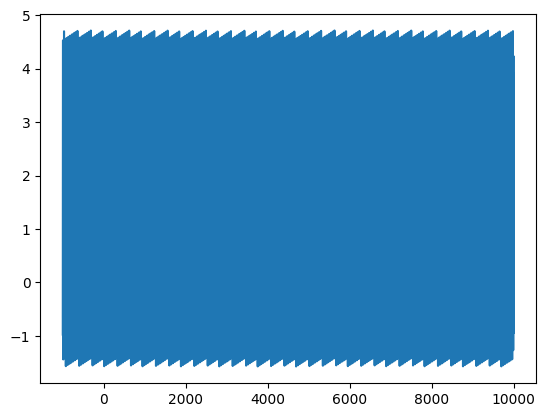

In [69]:
Y = np.linspace(-1000, 10000, 10000)
Z = - 2 * np.pi * np.floor((Y + np.pi / 2) / (2* np.pi)) + Y 
plt.plot(Y, Z)

/home/jovyan/project/MirrorDescent-DFT/drafts


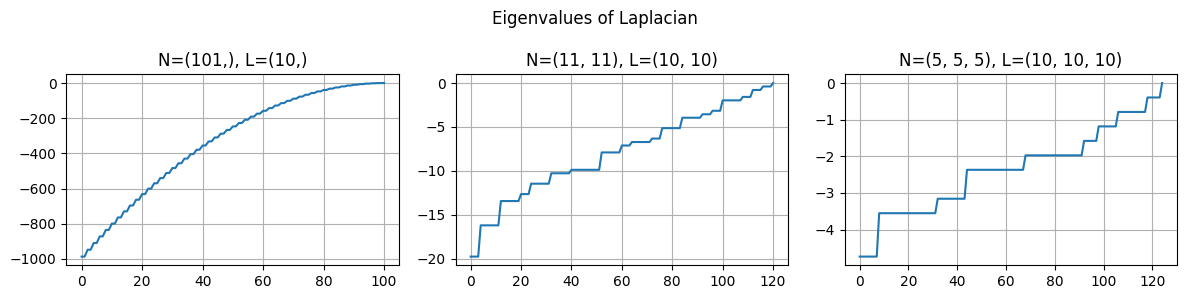

[Array([-9.86960440e+02, -9.86960440e+02, -9.47876807e+02, -9.47876807e+02,
       -9.09582742e+02, -9.09582742e+02, -8.72078245e+02, -8.72078245e+02,
       -8.35363317e+02, -8.35363317e+02, -7.99437956e+02, -7.99437956e+02,
       -7.64302165e+02, -7.64302165e+02, -7.29955942e+02, -7.29955942e+02,
       -6.96399287e+02, -6.96399287e+02, -6.63632200e+02, -6.63632200e+02,
       -6.31654682e+02, -6.31654682e+02, -6.00466732e+02, -6.00466732e+02,
       -5.70068350e+02, -5.70068350e+02, -5.40459537e+02, -5.40459537e+02,
       -5.11640292e+02, -5.11640292e+02, -4.83610616e+02, -4.83610616e+02,
       -4.56370508e+02, -4.56370508e+02, -4.29919968e+02, -4.29919968e+02,
       -4.04258996e+02, -4.04258996e+02, -3.79387593e+02, -3.79387593e+02,
       -3.55305758e+02, -3.55305758e+02, -3.32013492e+02, -3.32013492e+02,
       -3.09510794e+02, -3.09510794e+02, -2.87797664e+02, -2.87797664e+02,
       -2.66874103e+02, -2.66874103e+02, -2.46740110e+02, -2.46740110e+02,
       -2.27395685e+02, 

In [6]:
# Load modules 

import os 
import sys 

print(os.getcwd()) # print the current working directory
sys.path.append(os.path.join(os.getcwd(), '..')) # add the root directory to the path

from src import * # import everything from the src folder

Ns = [(101,), (11,11), (5,5,5)]
Ls = [(10,), (10,10), (10,10,10)]
Ds = []
plt.figure(figsize=(12,3), dpi=100)
for i, (N, L) in enumerate(zip(Ns, Ls)):
    D = genDiscretizedLaplacianEigenvalues(N, L) 
    D = D.flatten()
    D = D.sort()
    Ds.append(D)
    plt.subplot(1,3,i+1)
    plt.plot(D)
    plt.title(f"N={N}, L={L}")
    plt.grid(True)

plt.suptitle("Eigenvalues of Laplacian")
plt.tight_layout()
plt.show()

print(Ds)

In [ ]:
import os
os._exit(0)  # Force restart the process

: 